In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

In [9]:
df = pd.read_csv('house_price_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Dataset size: {df.size:,} data points")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nData Types:")
print(df.dtypes)

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

numerical_cols = df.select_dtypes(include=[np.number]).columns
print("\nOutliers Detection (IQR method):")
for col in numerical_cols:
    if col != 'property_id':
        outliers_count = detect_outliers_iqr(df, col)
        outliers_percent = (outliers_count / len(df)) * 100
        print(f"{col}: {outliers_count} outliers ({outliers_percent:.2f}%)")

Dataset shape: (8000, 25)
Dataset size: 200,000 data points

First 5 rows:
   property_id neighborhood  distance_to_city_center  distance_to_metro  \
0  PROP_000001  Forest Glen                      6.6                908   
1  PROP_000002     Lakeside                      2.6                 84   
2  PROP_000003     Downtown                     10.2                 50   
3  PROP_000004    Riverside                      5.1                475   
4  PROP_000005      Oakwood                      0.5                647   

   distance_to_school  crime_rate  house_age  total_area  bedrooms  bathrooms  \
0                 296         1.0         22         103         3          3   
1                  30         1.0         12         114         2          2   
2                 120         1.0         21          83         5          3   
3                  48         1.0          0         127         3          1   
4                 111         1.0         21          59         6   


Sale Price Skewness: 0.073
Data is approximately symmetric


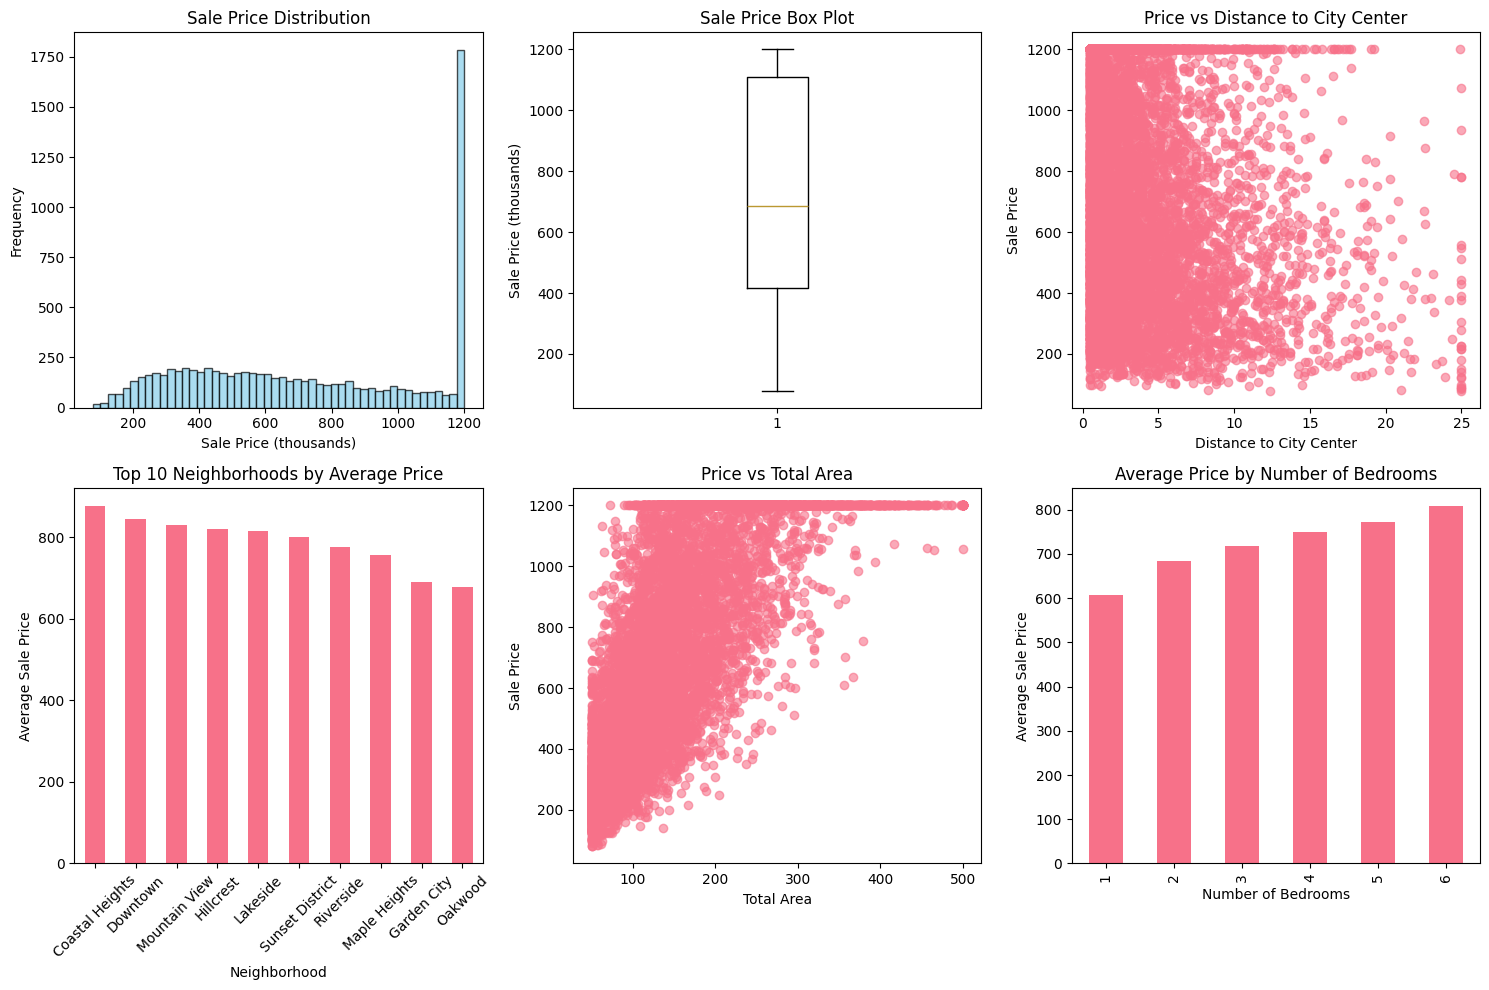

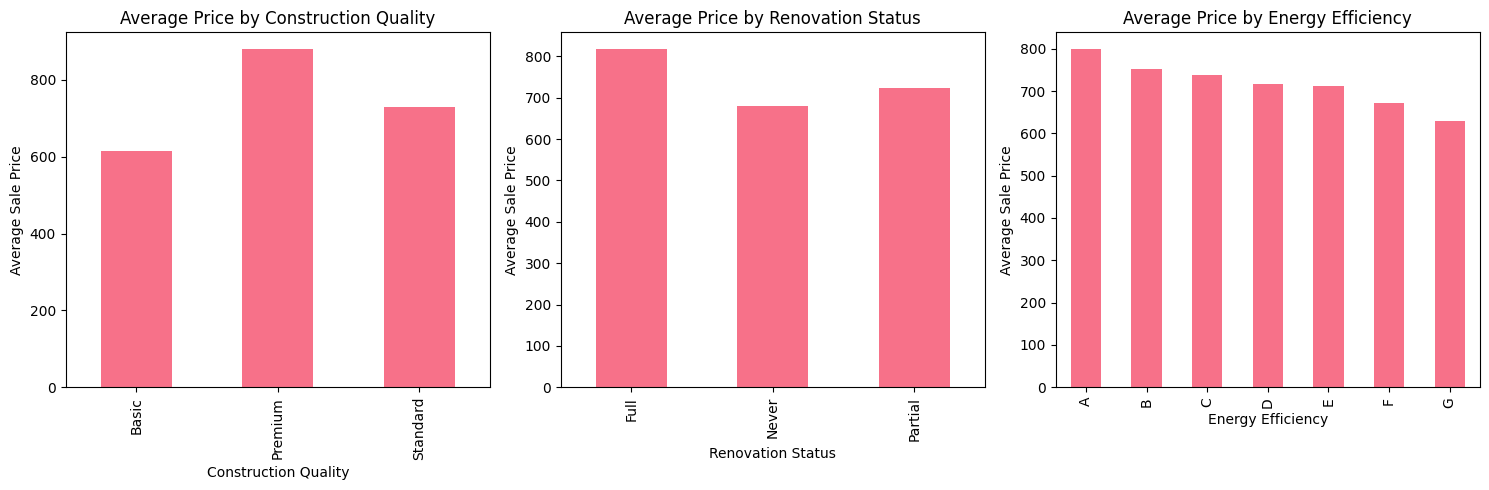

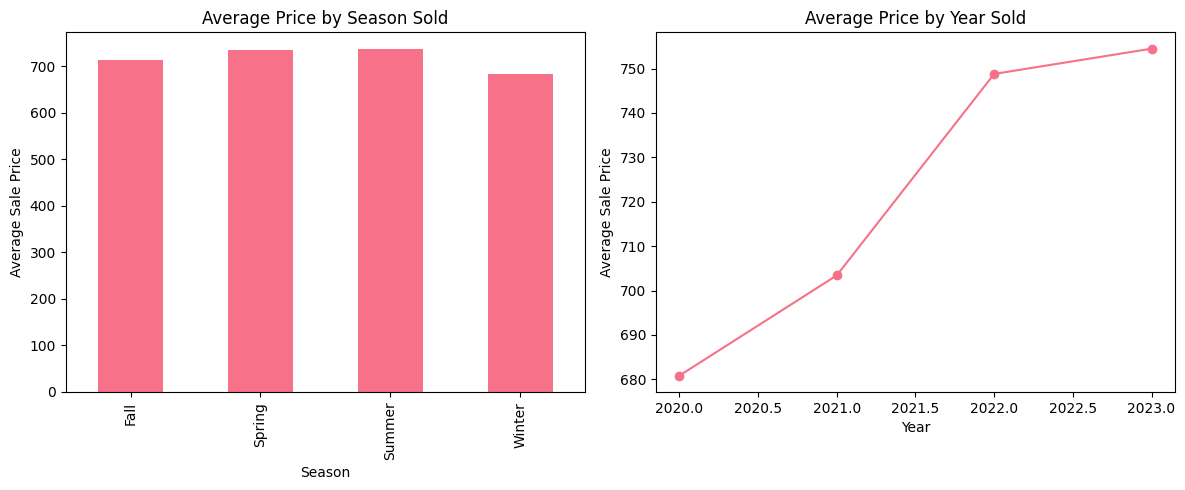

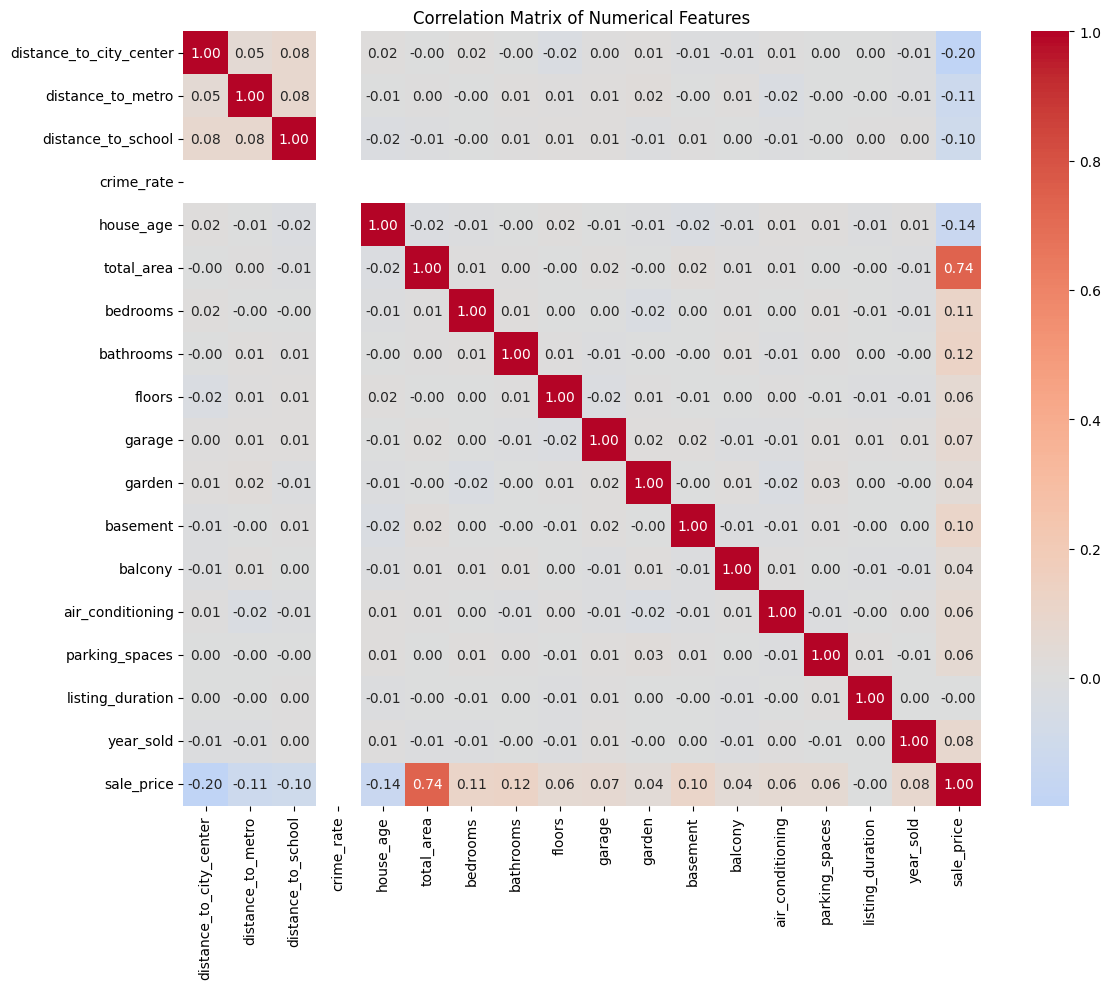


Correlations with Sale Price:
total_area                 0.740486
distance_to_city_center    0.197500
house_age                  0.144916
bathrooms                  0.122902
distance_to_metro          0.113570
bedrooms                   0.112459
basement                   0.102643
distance_to_school         0.100161
year_sold                  0.081629
garage                     0.070667
parking_spaces             0.063897
floors                     0.059866
air_conditioning           0.058422
balcony                    0.043994
garden                     0.036789
listing_duration           0.000285
crime_rate                      NaN
Name: sale_price, dtype: float64

High Correlations Between Features (> 0.7):
total_area - sale_price: 0.740


In [10]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['sale_price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price (thousands)')
plt.ylabel('Frequency')

# Check for skewness
skewness = df['sale_price'].skew()
print(f"\nSale Price Skewness: {skewness:.3f}")
if abs(skewness) > 1:
    print("Data is highly skewed")
elif abs(skewness) > 0.5:
    print("Data is moderately skewed")
else:
    print("Data is approximately symmetric")

plt.subplot(2, 3, 2)
plt.boxplot(df['sale_price'])
plt.title('Sale Price Box Plot')
plt.ylabel('Sale Price (thousands)')

# Location impact analysis
plt.subplot(2, 3, 3)
plt.scatter(df['distance_to_city_center'], df['sale_price'], alpha=0.6)
plt.title('Price vs Distance to City Center')
plt.xlabel('Distance to City Center')
plt.ylabel('Sale Price')

plt.subplot(2, 3, 4)
neighborhood_prices = df.groupby('neighborhood')['sale_price'].mean().sort_values(ascending=False)
neighborhood_prices.head(10).plot(kind='bar')
plt.title('Top 10 Neighborhoods by Average Price')
plt.xlabel('Neighborhood')
plt.ylabel('Average Sale Price')
plt.xticks(rotation=45)

# Property characteristics analysis
plt.subplot(2, 3, 5)
plt.scatter(df['total_area'], df['sale_price'], alpha=0.6)
plt.title('Price vs Total Area')
plt.xlabel('Total Area')
plt.ylabel('Sale Price')

plt.subplot(2, 3, 6)
bedroom_prices = df.groupby('bedrooms')['sale_price'].mean()
bedroom_prices.plot(kind='bar')
plt.title('Average Price by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Sale Price')

plt.tight_layout()
plt.show()

# Quality factors analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
quality_prices = df.groupby('construction_quality')['sale_price'].mean()
quality_prices.plot(kind='bar')
plt.title('Average Price by Construction Quality')
plt.xlabel('Construction Quality')
plt.ylabel('Average Sale Price')

plt.subplot(1, 3, 2)
renovation_prices = df.groupby('renovation_status')['sale_price'].mean()
renovation_prices.plot(kind='bar')
plt.title('Average Price by Renovation Status')
plt.xlabel('Renovation Status')
plt.ylabel('Average Sale Price')

plt.subplot(1, 3, 3)
energy_prices = df.groupby('energy_efficiency')['sale_price'].mean()
energy_prices.plot(kind='bar')
plt.title('Average Price by Energy Efficiency')
plt.xlabel('Energy Efficiency')
plt.ylabel('Average Sale Price')

plt.tight_layout()
plt.show()

# Market timing effects
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
season_prices = df.groupby('season_sold')['sale_price'].mean()
season_prices.plot(kind='bar')
plt.title('Average Price by Season Sold')
plt.xlabel('Season')
plt.ylabel('Average Sale Price')

plt.subplot(1, 2, 2)
year_prices = df.groupby('year_sold')['sale_price'].mean()
year_prices.plot(kind='line', marker='o')
plt.title('Average Price by Year Sold')
plt.xlabel('Year')
plt.ylabel('Average Sale Price')

plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Identify high correlations with sale_price
price_correlations = correlation_matrix['sale_price'].abs().sort_values(ascending=False)
print("\nCorrelations with Sale Price:")
print(price_correlations[1:])  # Exclude self-correlation

# Check for multicollinearity
print("\nHigh Correlations Between Features (> 0.7):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            corr_val = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((col1, col2, corr_val))
            print(f"{col1} - {col2}: {corr_val:.3f}")


In [11]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle categorical variables
categorical_cols = ['neighborhood', 'construction_quality', 'renovation_status', 
                   'heating_type', 'energy_efficiency', 'season_sold']

# Label encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Create new features
print("\nCreating new features...")

# Age categories
df_processed['age_category'] = pd.cut(df_processed['house_age'], 
                                    bins=[0, 5, 15, 30, 100], 
                                    labels=['New', 'Recent', 'Mature', 'Old'])
df_processed['age_category_encoded'] = LabelEncoder().fit_transform(df_processed['age_category'])

# Total rooms
df_processed['total_rooms'] = df_processed['bedrooms'] + df_processed['bathrooms']

# Area per room
df_processed['area_per_room'] = df_processed['total_area'] / df_processed['total_rooms']

# Luxury score (based on amenities)
amenity_cols = ['garage', 'garden', 'basement', 'balcony', 'air_conditioning']
df_processed['luxury_score'] = df_processed[amenity_cols].sum(axis=1)

# Location convenience score
df_processed['location_score'] = (1/df_processed['distance_to_city_center'] + 
                                 1/df_processed['distance_to_metro'] + 
                                 1/df_processed['distance_to_school'])

print("New features created:")
print("- age_category_encoded")
print("- total_rooms")
print("- area_per_room")
print("- luxury_score")
print("- location_score")

# Handle outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for key numerical features
original_length = len(df_processed)
key_features = ['sale_price', 'total_area', 'distance_to_city_center']

for feature in key_features:
    df_processed = remove_outliers_iqr(df_processed, feature)

print(f"\nOutlier removal: {original_length - len(df_processed)} rows removed")
print(f"Final dataset size: {len(df_processed)} rows")

# Select features for modeling
feature_columns = ['distance_to_city_center', 'distance_to_metro', 'distance_to_school',
                  'crime_rate', 'house_age', 'total_area', 'bedrooms', 'bathrooms',
                  'floors', 'garage', 'garden', 'basement', 'balcony',
                  'air_conditioning', 'parking_spaces', 'listing_duration',
                  'year_sold', 'neighborhood_encoded', 'construction_quality_encoded',
                  'renovation_status_encoded', 'heating_type_encoded',
                  'energy_efficiency_encoded', 'season_sold_encoded',
                  'age_category_encoded', 'total_rooms', 'area_per_room',
                  'luxury_score', 'location_score']

X = df_processed[feature_columns]
y = df_processed['sale_price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Encoded neighborhood: 15 unique values
Encoded construction_quality: 3 unique values
Encoded renovation_status: 3 unique values
Encoded heating_type: 3 unique values
Encoded energy_efficiency: 7 unique values
Encoded season_sold: 4 unique values

Creating new features...
New features created:
- age_category_encoded
- total_rooms
- area_per_room
- luxury_score
- location_score

Outlier removal: 645 rows removed
Final dataset size: 7355 rows

Data split completed:
Training set: 5884 samples
Test set: 1471 samples
Number of features: 28
Feature scaling completed


In [12]:
# Implement Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("Linear Regression model trained successfully")
print(f"Model coefficients shape: {lr_model.coef_.shape}")
print(f"Model intercept: {lr_model.intercept_:.2f}")

# Feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10)[['Feature', 'Coefficient']])

Linear Regression model trained successfully
Model coefficients shape: (28,)
Model intercept: 727.95

Top 10 Most Important Features:
                         Feature  Coefficient
5                     total_area   262.423103
4                      house_age   -43.910672
18  construction_quality_encoded    41.244656
0        distance_to_city_center   -34.688178
1              distance_to_metro   -33.772913
21     energy_efficiency_encoded   -32.575896
16                     year_sold    31.585279
24                   total_rooms    27.844966
2             distance_to_school   -27.629302
7                      bathrooms    26.063060



Training Set Metrics:
MAE (Mean Absolute Error): 141.92
MSE (Mean Squared Error): 31771.86
RMSE (Root Mean Squared Error): 178.25
R² (R-squared): 0.7344

Test Set Metrics:
MAE (Mean Absolute Error): 148.39
MSE (Mean Squared Error): 34734.23
RMSE (Root Mean Squared Error): 186.37
R² (R-squared): 0.7130


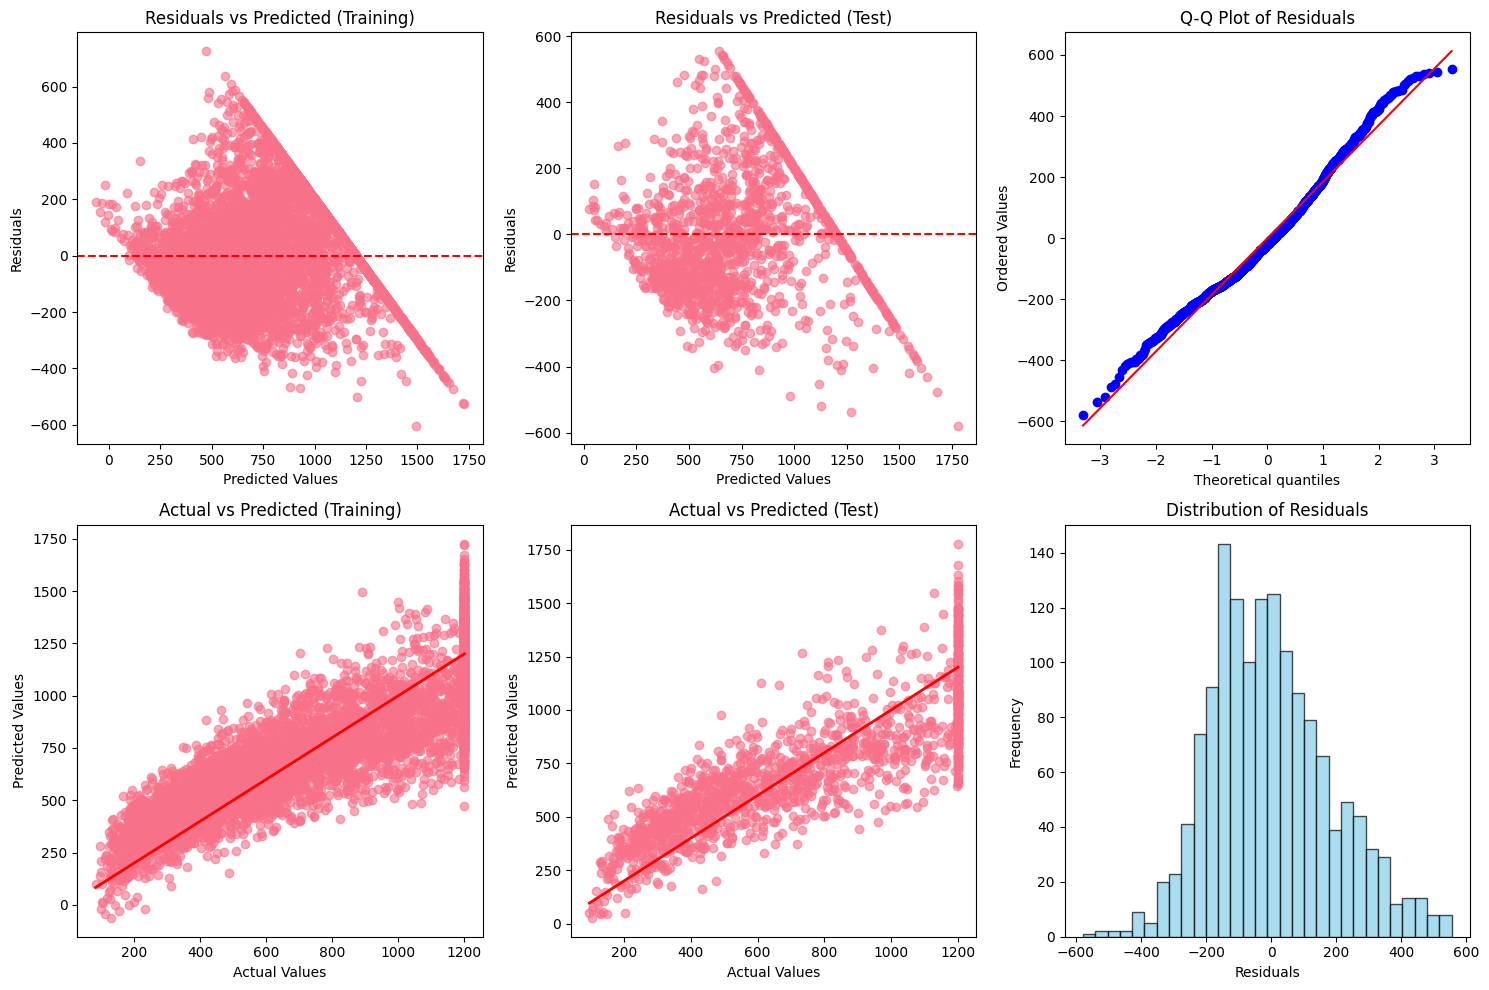

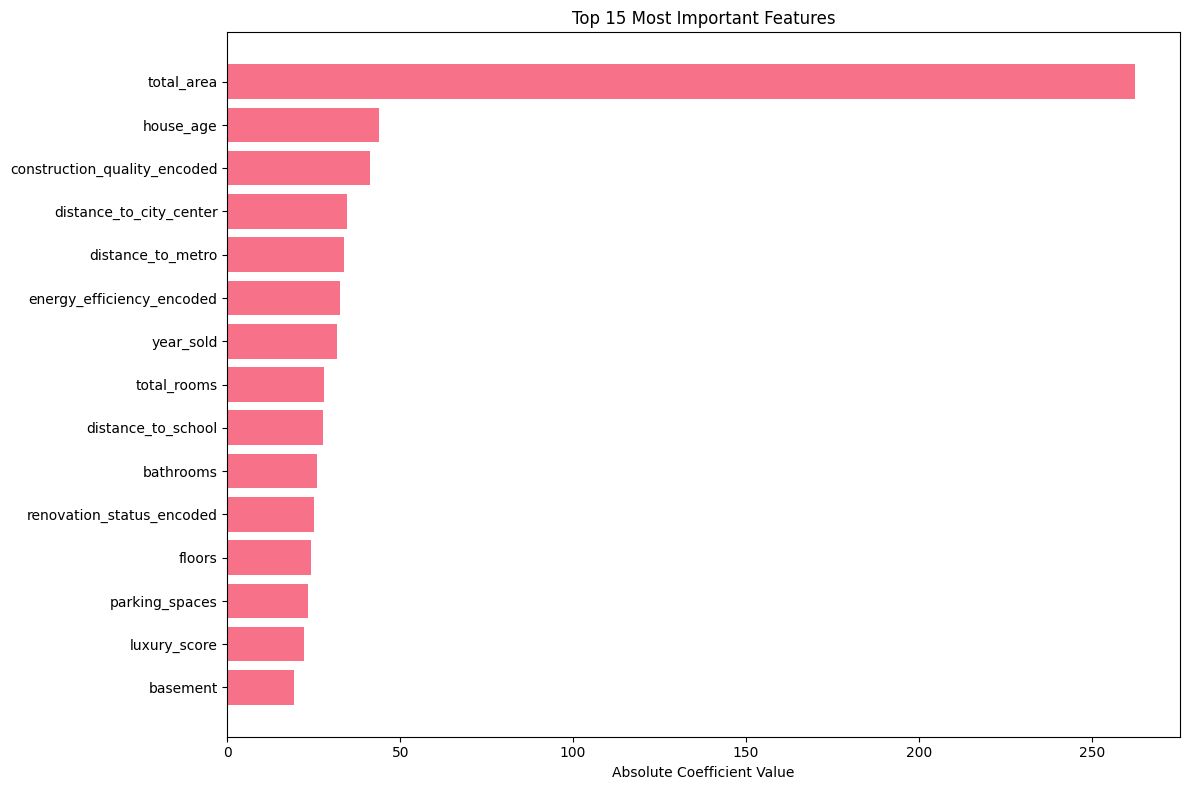


MODEL PERFORMANCE SUMMARY
Model: Linear Regression
Training Samples: 5884
Test Samples: 1471
Features Used: 28

Final Model Performance:
Test R²: 0.7130
Test RMSE: 186.37 thousand dollars
Test MAE: 148.39 thousand dollars

Overfitting Check:
Training R²: 0.7344
Test R²: 0.7130
Difference: 0.0214
✅ Good generalization (small gap between train and test performance)


In [13]:
# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Metrics:")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"MSE (Mean Squared Error): {mse:.2f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"R² (R-squared): {r2:.4f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Evaluate on training and test sets
train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

# Create residual plots
plt.figure(figsize=(15, 10))

# Residuals vs Predicted (Training)
plt.subplot(2, 3, 1)
train_residuals = y_train - y_train_pred
plt.scatter(y_train_pred, train_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Training)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Residuals vs Predicted (Test)
plt.subplot(2, 3, 2)
test_residuals = y_test - y_test_pred
plt.scatter(y_test_pred, test_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Test)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# QQ plot for residuals normality check
from scipy import stats
plt.subplot(2, 3, 3)
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

# Actual vs Predicted (Training)
plt.subplot(2, 3, 4)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'red', lw=2)
plt.title('Actual vs Predicted (Training)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Actual vs Predicted (Test)
plt.subplot(2, 3, 5)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', lw=2)
plt.title('Actual vs Predicted (Test)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Distribution of residuals
plt.subplot(2, 3, 6)
plt.hist(test_residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature importance visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Abs_Coefficient'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Model performance summary
print("\n" + "=" * 50)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 50)

print(f"Model: Linear Regression")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")
print(f"Features Used: {X_train.shape[1]}")

print(f"\nFinal Model Performance:")
print(f"Test R²: {test_metrics['R2']:.4f}")
print(f"Test RMSE: {test_metrics['RMSE']:.2f} thousand dollars")
print(f"Test MAE: {test_metrics['MAE']:.2f} thousand dollars")

# Check for overfitting
print(f"\nOverfitting Check:")
print(f"Training R²: {train_metrics['R2']:.4f}")
print(f"Test R²: {test_metrics['R2']:.4f}")
print(f"Difference: {train_metrics['R2'] - test_metrics['R2']:.4f}")

if train_metrics['R2'] - test_metrics['R2'] > 0.1:
    print("⚠️ Model may be overfitting (large gap between train and test performance)")
elif train_metrics['R2'] - test_metrics['R2'] < 0.05:
    print("✅ Good generalization (small gap between train and test performance)")
else:
    print("⚡ Moderate generalization")

